In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# Load raw dataset
file_path = 'ecommerce_customer_data_large.csv'
df = pd.read_csv(file_path)

In [3]:
# Inspect the dataset
print("Shape:", df.shape)
print(df.info())
print(df.head())

Shape: (247601, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247601 entries, 0 to 247600
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            247601 non-null  int64  
 1   Purchase Date          247601 non-null  object 
 2   Product Category       247601 non-null  object 
 3   Product Price          247601 non-null  int64  
 4   Quantity               247601 non-null  int64  
 5   Total Purchase Amount  247601 non-null  int64  
 6   Payment Method         247601 non-null  object 
 7   Customer Age           247601 non-null  int64  
 8   Returns                200678 non-null  float64
 9   Customer Name          247601 non-null  object 
 10  Age                    247601 non-null  int64  
 11  Gender                 247601 non-null  object 
 12  Churn                  247601 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.6+ MB
None
   Cus

In [4]:
# Rename columns for convenience
df.rename(columns={
    'Customer ID':            'customer_id',
    'Purchase Date':          'purchase_date',
    'Product Category':       'product_category',
    'Product Price':          'product_price',
    'Quantity':               'quantity',
    'Total Purchase Amount':  'total_amount',
    'Payment Method':         'payment_method',
    'Customer Age':           'customer_age',
    'Customer Name':          'customer_name',
    'Returns':                'returns',
    'Churn':                  'churn',
    # drop the extra 'Age' column below:
    'Age':                    'age_duplicate'
}, inplace=True)

In [5]:
# Handle missing & drop unneeded
# 'returns' is NaN when no return; fill with 0
df['returns'] = df['returns'].fillna(0).astype(int)
# drop the duplicate age col
df.drop(columns=['age_duplicate'], inplace=True)

In [6]:
# Convert purchase_date to datetime & extract features
df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')
# drop any unparseable dates
df = df.dropna(subset=['purchase_date'])
df['year']        = df['purchase_date'].dt.year
df['month']       = df['purchase_date'].dt.month
df['day_of_week'] = df['purchase_date'].dt.day_name()
df['hour']        = df['purchase_date'].dt.hour

In [7]:
# Remove exact duplicates
before = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped {before - df.shape[0]} duplicate rows")

Dropped 0 duplicate rows


In [8]:
# Final sanity checks
print("Missing by column:\n", df.isnull().sum())
print("Dtypes:\n", df.dtypes)

Missing by column:
 customer_id         0
purchase_date       0
product_category    0
product_price       0
quantity            0
total_amount        0
payment_method      0
customer_age        0
returns             0
customer_name       0
Gender              0
churn               0
year                0
month               0
day_of_week         0
hour                0
dtype: int64
Dtypes:
 customer_id                  int64
purchase_date       datetime64[ns]
product_category            object
product_price                int64
quantity                     int64
total_amount                 int64
payment_method              object
customer_age                 int64
returns                      int64
customer_name               object
Gender                      object
churn                        int64
year                         int32
month                        int32
day_of_week                 object
hour                         int32
dtype: object


In [9]:
# Define a new column "is_return" to flag them out
df['is_return'] = (df['returns'] > 0).astype(int)

# RFM
today = df['purchase_date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg(
    recency_days=('purchase_date', lambda x: (today - x.max()).days),
    frequency    =('customer_id','count'),
    monetary     =('total_amount','sum')
).reset_index()

# Merge RFM back
df = df.merge(rfm, on='customer_id', how='left')

In [10]:
# Save dataframe into a new csv file
df.to_csv('ecommerce_enriched.csv', index=False)

In [11]:
# Load enriched data
df = pd.read_csv('ecommerce_enriched.csv', parse_dates=['purchase_date'])

# Quick summaries
print("Shape:", df.shape)
print("Unique customers:", df['customer_id'].nunique())
print("Date range:", df['purchase_date'].min(), "to", df['purchase_date'].max())
print("\nTop categories by count:\n", df['product_category'].value_counts().head())
print("\nOrder value stats:\n", df['total_amount'].describe())

Shape: (247601, 20)
Unique customers: 49647
Date range: 2020-01-01 00:07:00 to 2023-08-31 23:58:00

Top categories by count:
 product_category
Clothing       61996
Electronics    61987
Home           61944
Books          61674
Name: count, dtype: int64

Order value stats:
 count    247601.000000
mean       2725.224422
std        1442.536632
min         100.000000
25%        1476.000000
50%        2725.000000
75%        3974.000000
max        5350.000000
Name: total_amount, dtype: float64


In [12]:
# Aggregate by category
cat_stats = df.groupby('product_category').agg(
    total_spend = ('total_amount', 'sum'),
    count       = ('customer_id', 'size')
).sort_values(by='count', ascending=False)

In [13]:
# Category level counts and spend
cat_stats = df.groupby('product_category').agg(
    count=('customer_id','size'),
    total_spend=('total_amount','sum')
).sort_values('count', ascending=False)

In [14]:
# Average price per item
df['avg_price_per_item'] = df['total_amount'] / df['quantity']

# Age groups
bins  = [18, 25, 35, 50, 65, 100]
labels = ['18–24','25–34','35–49','50–64','65+']
df['age_group'] = pd.cut(df['customer_age'], bins=bins, labels=labels, right=False)

# Return flag
df['is_return'] = (df['returns'] > 0).astype(int)

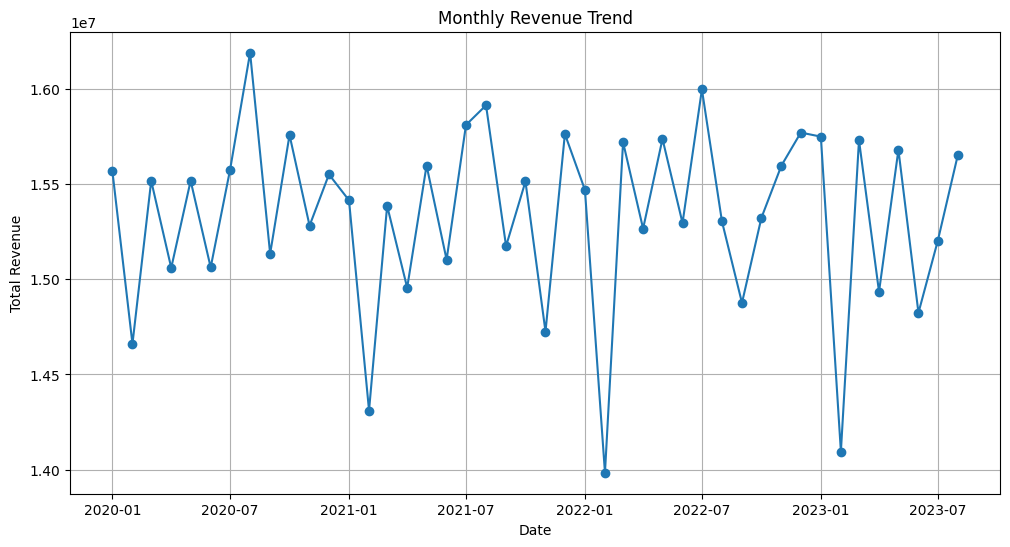

In [16]:
# Data visulaization part

# Monthly sales trend
monthly_sales = df.groupby(['year', 'month'])['total_amount'].sum().reset_index()
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['year_month'], monthly_sales['total_amount'], marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

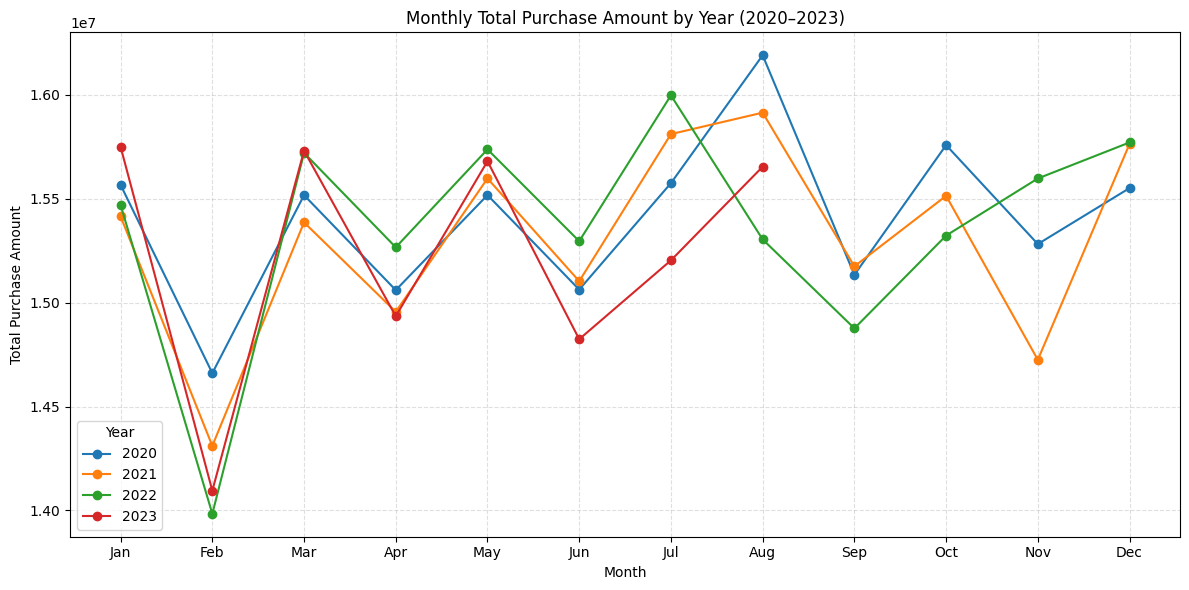

In [15]:
# Ensure datetime format
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Extract year and month
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month

# Filter only years 2020–2023
df_filtered = df[df['year'].isin([2020, 2021, 2022, 2023])]

# Group by year and month, sum total_amount
df_monthly = df_filtered.groupby(['year', 'month'])['total_amount'].sum().reset_index()

# Pivot to have years as separate lines
df_pivot = df_monthly.pivot(index='month', columns='year', values='total_amount')

# Plot
plt.figure(figsize=(12, 6))

for year in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[year], label=str(year), marker='o')

# Customize x-axis as month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=month_labels)

plt.title('Monthly Total Purchase Amount by Year (2020–2023)')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

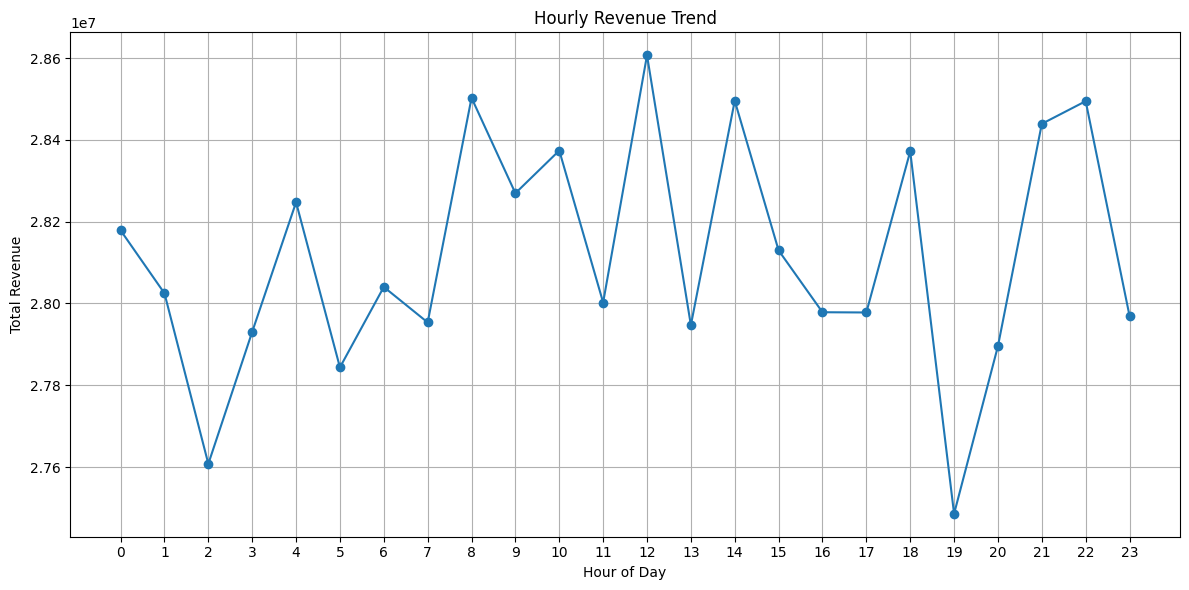

In [17]:
# Group by hour and sum total_amount
hourly_sales = df.groupby('hour', observed=True)['total_amount'].sum().reset_index()

# Plot the hourly trend
plt.figure(figsize=(12,6))
plt.plot(hourly_sales['hour'], hourly_sales['total_amount'], marker='o', linestyle='-')
plt.title('Hourly Revenue Trend')
plt.xlabel('Hour of Day')
plt.ylabel('Total Revenue')
plt.xticks(range(0, 24))  # Show every hour on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

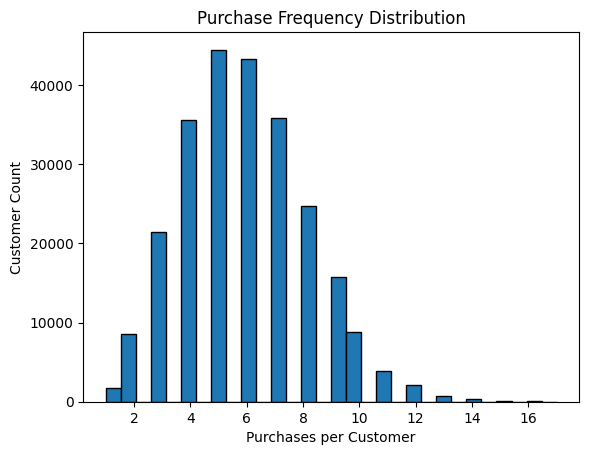

In [18]:
# Customer Behavior Funnel
plt.hist(df['frequency'], bins=30, edgecolor='black')
plt.title('Purchase Frequency Distribution')
plt.xlabel('Purchases per Customer')
plt.ylabel('Customer Count')
plt.show()

In [20]:
# Bin ages
age_bins = [0, 21, 41, 61, 100]
age_labels = ['<21', '21-40', '41-60', '61+']
df['age_group'] = pd.cut(df['customer_age'], bins=age_bins, labels=age_labels, right=False)

# Bin prices
price_bins = [0, 100, 200, 300, 400, 500]
price_labels = ['0-99', '100-199', '200-299', '300-399', '400-500']
df['price_group'] = pd.cut(df['product_price'], bins=price_bins, labels=price_labels, right=True)

# Aggregate by age group and price group
agg = df.groupby(['age_group', 'price_group'], observed=True)['product_price'].sum().reset_index()

# Sunburst plot
fig = px.sunburst(
    agg,
    path=['age_group', 'price_group'],
    values='product_price',
    color='product_price',
    color_continuous_scale='Reds',
    title="Total Spend by Age Group (Inner circle) and Price Range ($0-$500)"
)

fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

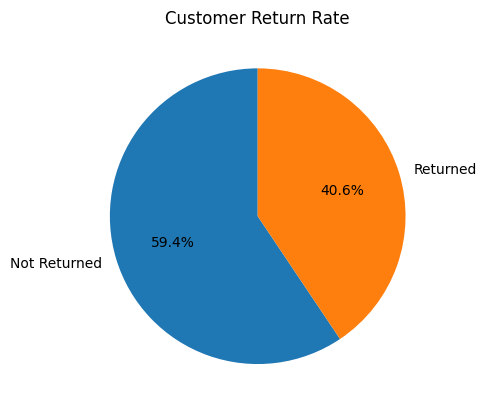

In [19]:
# Returns vs Purchases
returns_summary = df['is_return'].value_counts()
returns_summary.plot(kind='pie', labels=['Not Returned', 'Returned'], autopct='%1.1f%%', startangle=90)
plt.title('Customer Return Rate')
plt.ylabel('')
plt.show()

In [1]:
# Load Dataset again for model 
df = pd.read_csv('ecommerce_enriched.csv', parse_dates=['purchase_date'])

# Feature Engineering 
df['avg_price_per_item'] = df['total_amount'] / df['quantity']

# Customer-level return rate
cust_ret = df.groupby('customer_id')['is_return'].mean()
df['cust_return_rate'] = df['customer_id'].map(cust_ret)

# Product-level return rate
prod_ret = df.groupby('product_category')['is_return'].mean()
df['prod_return_rate'] = df['product_category'].map(prod_ret)

# RFM metrics
today = df['purchase_date'].max() + dt.timedelta(days=1)
rfm = df.groupby('customer_id').agg(
    recency_days_x=('purchase_date', lambda x: (today - x.max()).days),
    frequency_x=('customer_id', 'count'),
    monetary_x=('total_amount', 'sum')
).reset_index()
df = df.merge(rfm, on='customer_id', how='left')

# Time features
df['hour'] = df['purchase_date'].dt.hour
df['is_weekend'] = df['purchase_date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

# Prepare Features and Target 
y = df['is_return']

num_cols = [
    'total_amount', 'avg_price_per_item', 'quantity', 'customer_age',
    'cust_return_rate', 'prod_return_rate', 'recency_days_x',
    'frequency_x', 'monetary_x', 'hour', 'is_weekend'
]
X_num = df[num_cols]

cat_cols = ['product_category', 'payment_method', 'day_of_week']
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat = pd.DataFrame(
    ohe.fit_transform(df[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=df.index
)

X = pd.concat([X_num, X_cat], axis=1)

# Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with Grid Search 
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [5, 10]
}
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid = GridSearchCV(
    rf_base, param_grid,
    cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

rf = grid.best_estimator_

# Evaluate Best Model on Test Set 
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nFinal Classification Report:\n", classification_report(y_test, y_pred))
print("Final Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC‑AUC:", roc_auc_score(y_test, y_proba))

# Feature Importance 
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\nTop 10 Features:\n", importances.sort_values(ascending=False).head(10))

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Final Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.68     29416
           1       0.57      0.75      0.64     20105

    accuracy                           0.67     49521
   macro avg       0.67      0.68      0.66     49521
weighted avg       0.69      0.67      0.67     49521

Final Confusion Matrix:
 [[17975 11441]
 [ 5100 15005]]
Test ROC‑AUC: 0.7512032812910355

Top 10 Features:
 cust_return_rate      0.901896
frequency_x           0.025732
monetary_x            0.017739
total_amount          0.010685
avg_price_per_item    0.010574
recency_days_x        0.009597
customer_age          0.006271
hour                  0.005367
quantity              0.002353
prod_return_rate      0.001784
dtype: float64
